References:
* **Bigram and trigram** in each category and in full text (https://www.kaggle.com/code/nilimajauhari/eda-for-textual-data-text-visualization/notebook)

* **Sentiment / emotion** in each category / product / full text (https://www.kaggle.com/code/krrai77/eda-for-text-data-nlp/notebook)

* **Text clustering, visulizaton, and topic modeling**: Kaggle notebook: https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering/notebook; Chapter 6. Clustering for Text Similarity in oreilly book: Applied Text Analysis with Python at https://learning-oreilly-com.ezproxy.torontopubliclibrary.ca/library/view/applied-text-analysis/9781491963036/ch06.html#idm140629384205920; source code on git at https://github.com/foxbook/atap/tree/master/snippets/ch06;



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#%ls /content/drive/MyDrive/career/data\ scientist/NLP/text\ analysis\ code\ examples
%ls /content/drive/MyDrive/career/data\ scientist/NLP/'text cleaning and analysis code examples'/

path = '/content/drive/MyDrive/career/data scientist/NLP/text cleaning and analysis code examples/'

'Html parsing and comparison of nltk and spacy in sentence segmentation.gdoc'
'Html parsing, remove accents, expand contraction, segmentation - py spark.gdoc'
'pipeline of text data analysis.gsheet'
 text_analysis_bigram_trigram_sentiment_emotion_text_clustering_tsne_topic_modeling.ipynb
 text_for_bigram_trigram.csv
 wordcloud.ipynb
'Wordcloud plot with customized stop words; most frequently used words.gdoc'


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# ingest the dataset into a Pandas dataframe
text_df = pd.read_csv(path+'text_for_bigram_trigram.csv')
text_df.head()


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,"@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r",NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm sure you won't! Because you don't have to!,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,"@105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back",119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k,119243,119240.0


In [5]:
text_df.shape

(93, 7)

# Remove stopwords

In [6]:
# Let us take a look at the number of stopwords in the tweets
nltk_stopword = stopwords.words('english')

text_df['stopwords'] = text_df['text'].apply(lambda x: len([x for x in x.split() if x in nltk_stopword]))
text_df[['text','stopwords']].head()

,text,stopwords
0,@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡,8
1,"@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r",6
2,@76328 I really hope you all change but I'm sure you won't! Because you don't have to!,7
3,"@105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back",7
4,@VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k,3


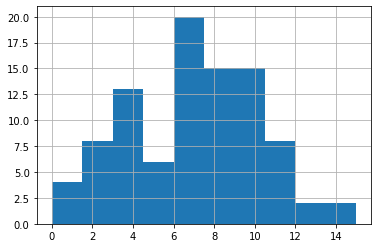

In [7]:
# Distribution of stopwords
text_df.text.map(lambda x: len([x for x in x.split() if x in nltk_stopword])).hist()

## add custom stopwords

In [8]:
custom_stopwords = ["twitter", "us"]
nltk_stopword.extend(custom_stopwords)

In [9]:
# Removing stopwords and punctuations from the tweets
text_df['text'] = text_df['text'].str.replace('@','')
text_df['text'].head()

text_df['text'] = text_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in nltk_stopword))
text_df['text'].head()

0                                                     AppleSupport causing reply disregarded tapped notification keyboard opened😡😡😡
1               105835 Your business means lot us. Please DM name, zip code additional details concern. ^RR https://t.co/znUu1VJn9r
2                                                                            76328 I really hope change I'm sure won't! Because to!
3    105836 LiveChat online moment - https://t.co/SY94VtU8Kq contact 03331 031 031 option 1, 4, 3 (Leave message) request call back
4             VirginTrains see attached error message. I've tried leaving voicemail several times past week https://t.co/NxVZjlYx1k
Name: text, dtype: object

# Bigram and Trigram

In [10]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

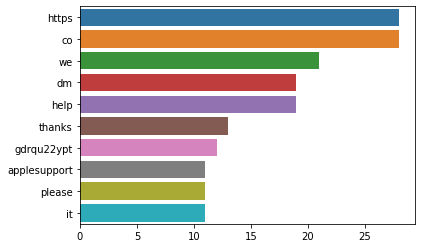

In [11]:
# Visualising the most frequent unigrams in the tweets
top_unigrams = get_top_ngram(text_df['text'],1)[:10]
x,y = map(list,zip(*top_unigrams))
sns.barplot(x = y,y = x);

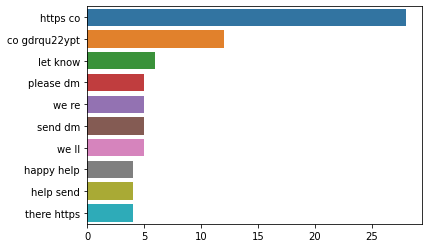

In [12]:
# Visualising the most frequent bigrams in the tweets
top_bigrams = get_top_ngram(text_df['text'],2)[:10]
x,y = map(list,zip(*top_bigrams))
sns.barplot(x = y,y = x)

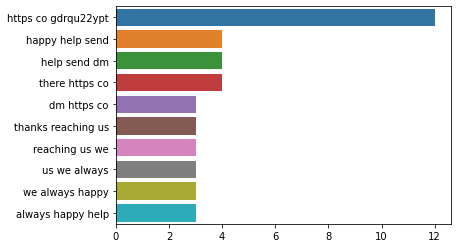

In [13]:
# Visualising the most frequent trigrams in the tweets
top_trigrams = get_top_ngram(text_df['text'],3)[:10]
x,y = map(list,zip(*top_trigrams))
sns.barplot(x = y,y = x)

# Sentiment / Emotion

Sentiment analysis is the process of determining the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within an online mention.

In [14]:
from textblob import TextBlob

In [15]:
#Polarity in sentiment analysis refers to identifying sentiment orientation (positive, neutral, and negative) in written or spoken language.

text_df['emotion']=text_df['text'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [16]:
text_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,stopwords,emotion
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,AppleSupport causing reply disregarded tapped notification keyboard opened😡😡😡,119236,NaN,8,0.000000
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,"105835 Your business means lot us. Please DM name, zip code additional details concern. ^RR https://t.co/znUu1VJn9r",NaN,119239.0,6,0.000000
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,76328 I really hope change I'm sure won't! Because to!,119238,NaN,7,0.490625
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,"105836 LiveChat online moment - https://t.co/SY94VtU8Kq contact 03331 031 031 option 1, 4, 3 (Leave message) request call back",119241,119242.0,7,0.000000
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,VirginTrains see attached error message. I've tried leaving voicemail several times past week https://t.co/NxVZjlYx1k,119243,119240.0,3,-0.125000


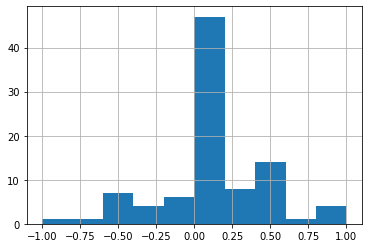

In [17]:
text_df.emotion.hist();

## positive

In [18]:
pos_threshold = 0.5
neg_threshold = -0.4

In [19]:
text_df[text_df['emotion']>pos_threshold]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,stopwords,emotion
15,119254,SpotifyCares,False,Wed Oct 11 13:41:25 +0000 2017,"105840 Hi there! What device happening on? If could also let know Android Spotify versions using, that'd great /AY",119255,119256.0,7,0.800
19,119259,SpotifyCares,False,Wed Oct 11 14:20:00 +0000 2017,"105840 That's great hear. If anything comes up, let know. We'll carry helping 🙂 /AY",119260,119258.0,4,0.800
20,119260,105840,True,Wed Oct 11 14:22:05 +0000 2017,SpotifyCares Brilliant thanks 😊,119261,119259.0,0,0.550
21,119261,SpotifyCares,False,Wed Oct 11 14:41:35 +0000 2017,"105840 You're welcome! If there's anything else help with, give shout. We're 😉 /CP",NaN,119260.0,7,1.000
23,119262,AppleSupport,False,Wed Oct 11 13:30:39 +0000 2017,105841 We'd love help! Please DM let know steps tried since experiencing behaviors. https://t.co/GDrqU22YpT,NaN,119263.0,5,0.625
31,119271,AppleSupport,False,Wed Oct 11 03:26:00 +0000 2017,105844 We'd happy help. Send DM start there. https://t.co/GDrqU22YpT,119270,119272.0,6,0.800


## negative

In [20]:
text_df[text_df['emotion']<neg_threshold]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,stopwords,emotion
14,119253,105839,True,Wed Oct 11 07:21:34 +0000 2017,I updated phone suddenly everything takes ages load wtf 76099 update sux I hate fix bye,119252,NaN,7,-0.433333
25,119264,British_Airways,False,Wed Oct 11 13:36:31 +0000 2017,"105842 We're sorry flight delayed, Beatner. Are travelling BA8733? If so, updated departure time 15:30. 1/2",NaN,119265.0,10,-0.500000
37,119277,sprintcare,False,Wed Oct 11 13:29:53 +0000 2017,105676 I understand frustrated situation be. Please follow sending DM assistance. Sprint Cares. -AC,NaN,119278.0,8,-0.700000
61,119301,105852,True,Wed Oct 11 08:50:14 +0000 2017,76099 AppleSupport fix update. It’s horrible,119300,NaN,1,-1.000000
62,119266,British_Airways,False,Wed Oct 11 13:37:15 +0000 2017,"105842 I appreciate 15:30 now, hopefully depart soon. We're sorry inconvenience delay caused. 2/2 ^JR",119302,119265.0,10,-0.500000
74,119315,105855,True,Wed Oct 11 12:14:41 +0000 2017,Got id's Tesco buying one Adnams Broadside. Is blind part job-spec? I 35 99 kilos.,"119316,119314",NaN,6,-0.500000
90,119332,Tesco,False,Wed Oct 11 13:34:06 +0000 2017,"105861 Hey Sara, sorry hear issues having, I ask lay speed website responding? TY - Chris",119333,119334.0,15,-0.500000


## neutral

In [21]:
text_df[text_df['emotion']==0].tail()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,stopwords,emotion
78,119321,105856,True,Wed Oct 11 13:48:39 +0000 2017,Tesco Done that. Still telling delivery slots whatsoever.,119322,119320.0,5,0.0
83,119325,AppleSupport,False,Wed Oct 11 00:19:34 +0000 2017,105857 We'd like help can. When start happening? Which version iOS running currently?,119324,119326.0,8,0.0
86,119328,105858,True,Wed Oct 11 02:04:50 +0000 2017,HPSupport Problem printhead Serial# TH536D1HN #hpcswus #hpprnt,119327,NaN,1,0.0
87,119329,UPSHelp,False,Wed Oct 11 13:56:00 +0000 2017,105859 UPS service called My Choice allow packages delivered UPS Store. ^ML https://t.co/BPZKndqww1 https://t.co/wKJHDXWGRQ,NaN,119330.0,8,0.0
88,119330,105859,True,Wed Oct 11 13:50:42 +0000 2017,105860 I wish Amazon option I get shipped ups store I avoid lot struggle,119329,119331.0,14,0.0


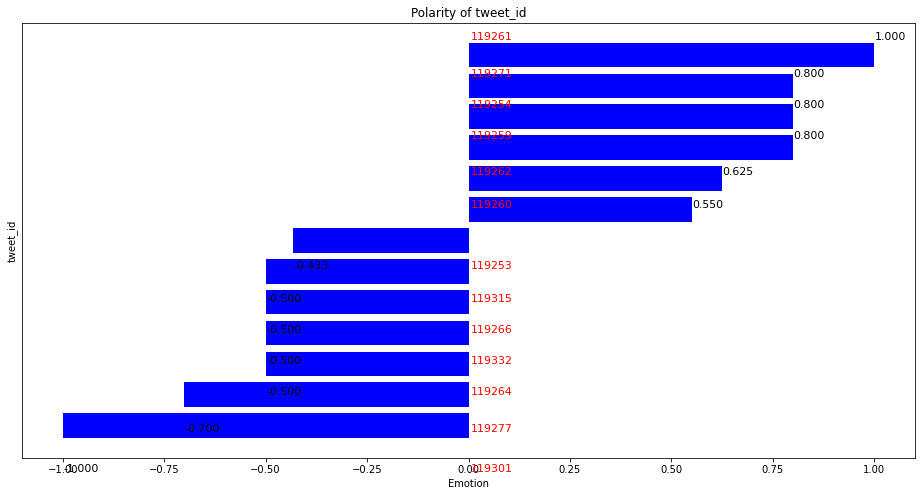

In [22]:
product_polarity=pd.DataFrame(text_df.groupby('tweet_id')['emotion'].mean().sort_values(ascending=True))

# two ends
product_polarity = product_polarity[(product_polarity.emotion>pos_threshold) | (product_polarity.emotion<neg_threshold)]

plt.figure(figsize=(16,8))
plt.xlabel('Emotion')
plt.ylabel('tweet_id')
plt.title('Polarity of tweet_id')
polarity_graph=plt.barh(np.arange(len(product_polarity.index)),product_polarity['emotion'],color='blue')


for bar,product in zip(polarity_graph,product_polarity.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='red')

for bar,polarity in zip(polarity_graph,product_polarity['emotion']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

# Text Clustering

## vectorize

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [24]:
text = text_df['text'].values
max_features = 2**12

X = vectorize(text, max_features)

In [25]:
X.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.2705798, 0.2705798,
        0.2705798],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

## dimensionality reduction with PCA

reduce the dimensions while still keeping 95% variance

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(93, 81)

## KMeans

To separate the text, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [27]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

### find optimal n_clusters with elbow plot

In [28]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 6)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

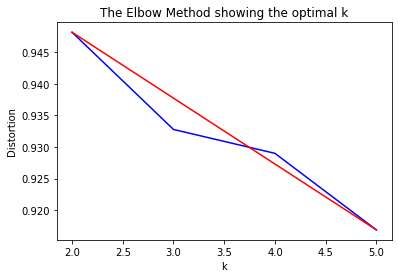

In [29]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### run kmeans for clustering on text data

In [30]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
text_df['predicted'] = y_pred

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff109ce1610>]],
      dtype=object)

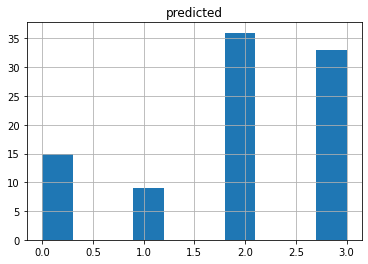

In [31]:
text_df[['predicted']].hist()

In [32]:
display(text_df[text_df['predicted']==0][['text','predicted']].head(3))

display(text_df[text_df['predicted']==1][['text','predicted']].head(3))

display(text_df[text_df['predicted']==2][['text','predicted']].head(3))

display(text_df[text_df['predicted']==3][['text','predicted']].head(3))

,text,predicted
0,AppleSupport causing reply disregarded tapped notification keyboard opened😡😡😡,0
11,"105838 AppleSupport Me suffering , hope find solution",0
12,"AppleSupport hi #apple, I’ve concern latest ios slow #iphone6 happy it. Any solution please?",0


,text,predicted
21,"105840 You're welcome! If there's anything else help with, give shout. We're 😉 /CP",1
68,"105855 Hi Thomas, colleague believes person buying alcohol looks 25, challenged ID prove they're age. - Paige",1
70,Tesco The point enforced properly don't. Plus take common-sense think person look 18?,1


,text,predicted
2,76328 I really hope change I'm sure won't! Because to!,2
3,"105836 LiveChat online moment - https://t.co/SY94VtU8Kq contact 03331 031 031 option 1, 4, 3 (Leave message) request call back",2
4,VirginTrains see attached error message. I've tried leaving voicemail several times past week https://t.co/NxVZjlYx1k,2


,text,predicted
1,"105835 Your business means lot us. Please DM name, zip code additional details concern. ^RR https://t.co/znUu1VJn9r",3
8,VirginTrains I still heard &amp; number I'm directed phone dead end &amp; live chat work. Can someone call me?,3
10,105837 We help. Which version iOS on? You find Settings &gt; General &gt; About. Reply DM. https://t.co/GDrqU22YpT,3


## visulization: t-sne for text dimensionality reduction

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 92 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.341978
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.420387
[t-SNE] KL divergence after 800 iterations: 0.352584


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


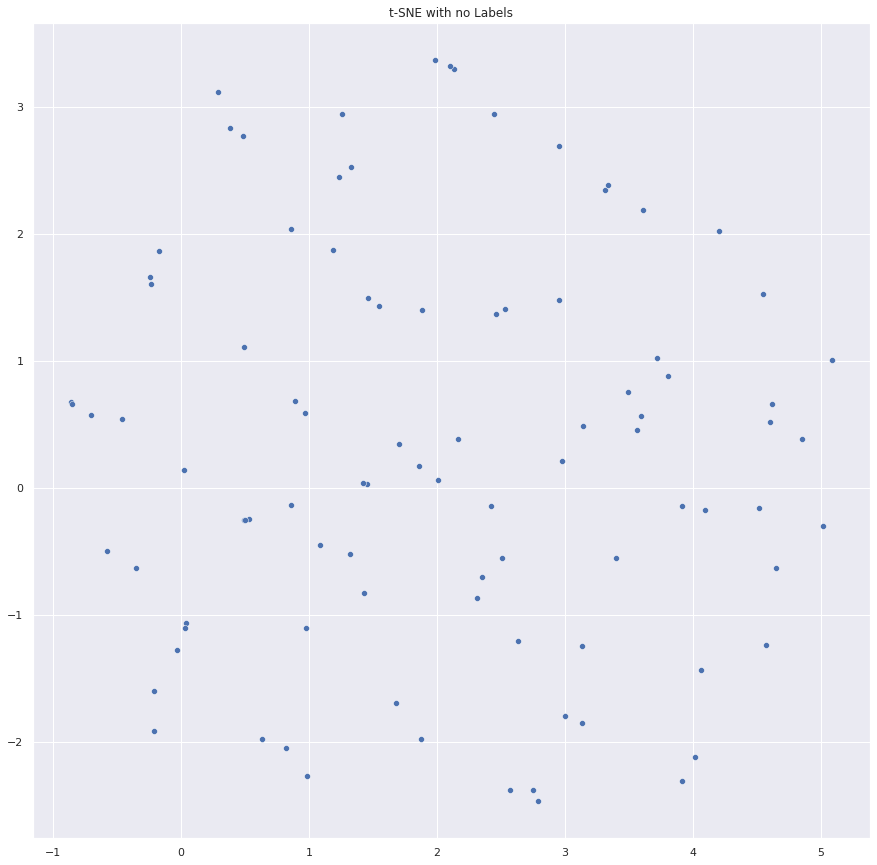

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. t-SNE was able to reduce the dimensionality of the texts, but now clustering is required.
Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


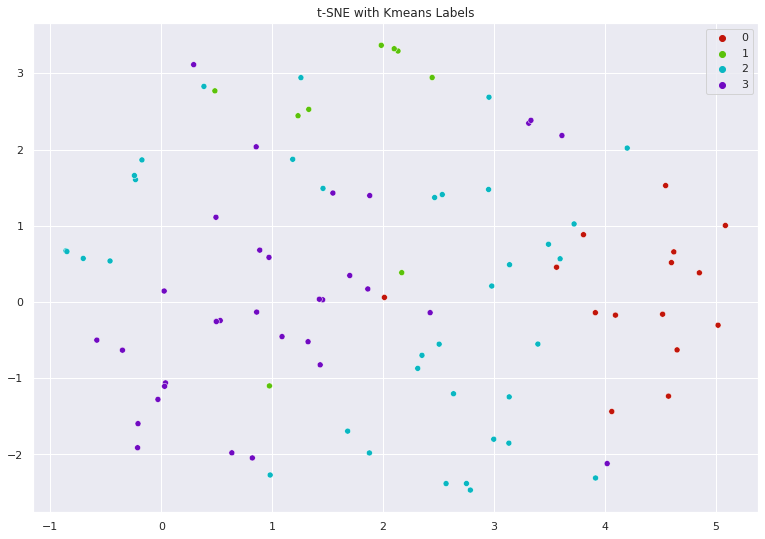

In [35]:
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
# 4 here is the number of clusters from kmeans
palette = sns.hls_palette(4, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. Interestingly, both k-means and t-SNE can find independent clusters even though they were run independently. This shows that structure within the literature can be observed and measured to some extent.

# Topic Modeling on Each Cluster

In statistics and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for **discovery of hidden semantic structures in a text body**.

## LDA LatentDirichletAllocation

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). 
This is a generative statistical model that allows sets of words to be explained by a shared topic.

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
# create 4 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 4):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', 
                                       lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [38]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [39]:
# vectorize the data from each of our clusters

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(text_df.loc[text_df['predicted'] == current_cluster, 'text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 1


In [40]:
# create a corresponding LDA model for each cluster

# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 4


lda_models = []

for ii in range(0, NUM_TOPICS_PER_CLUSTER):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=4,
                          random_state=42, verbose=False)

In [41]:
# fit_transform all the LDA models on their respective cluster vectors

clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


In [42]:
# Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [43]:
# Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
all_keywords

[['applesupport', 'ios'],
 ['device', 'thanks', 'spotifycares'],
 ['https', 'ypt', 'gdrqu', 'thanks', 'look', 'send', 'sorry', 'help']]